In [1]:
import numpy as np
from gradvi.normal_means import NormalMeans, NormalMeansFromPosterior
from gradvi.models import basis_matrix
from gradvi.tests import toy_priors, toy_data

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 72)

# Local imports
import tf_data
import tf_methods
import utils

## Derivative of g and s2 at the optimum of penalty function at fixed b

In [2]:
from scipy import optimize as sp_optimize

def nm_penalty(b, prior, s2, dj, jac = True, 
                         invert_method = 'trisection', invert_options = {}):
    """
    Calculate the penalty term of the objective function 
    and its gradients with respect to the parameters
    """
    sj2 = s2 / dj

    nm = NormalMeansFromPosterior(
            b, prior, sj2,
            scale = s2, d = dj,
            method = invert_method, **invert_options)

    Pb, dPdb, dPdw, dPdsj2 = nm.penalty_operator(jac = True)
    h = np.sum(Pb)
    if jac:
        dhdb  = dPdb.copy()
        dhdw  = np.sum(dPdw, axis = 0)
        dhda  = prior.wmod_grad(dhdw)
        dhds2 = np.sum(dPdsj2 / dj)
        return h, dhdb, dhda, dhds2
    return h

def minimize_penalty(b, prior, s2init, dj):
    
    global _prior
    _prior = prior.copy()
    
    def funjac(params, b, dj):
        global _prior
        k  = _prior.k
        ak = params[:k]
        s2 = params[k]
        _prior.update_wmod(ak)
        h, _, dhda, dhds2 = nm_penalty(b, _prior, s2, dj)
        dhdx = np.concatenate((dhda, np.array([dhds2])))
        return h, dhdx
    
    xinit  = np.concatenate((_prior.wmod, np.array([s2init])))
    args   = (b, dj)
    bounds = [(None, None) for x in range(_prior.k)] + [(1e-8, None)]
    opt    = sp_optimize.minimize(funjac, xinit, args, 
                method = 'l-bfgs-b', bounds = bounds, jac = True, 
                options = {'disp':True, 'maxiter': 1000})
    ak     = opt.x[:_prior.k]
    _prior.update_wmod(ak)
    s2     = opt.x[_prior.k]
    return opt, s2, _prior

In [3]:
n = 512

prior = toy_priors.get_ash_scaled(k = 20, sparsity = 0.9)
dj = np.square(np.random.normal(1, 0.5, size = n)) * n
s2true = 1.44
z, sj2 = toy_data.get_normal_means(prior, n = n, s2 = s2true, dj = dj)
nm = NormalMeans(z, prior, sj2, scale = s2true, d = dj)
b  = nm.analytical_posterior_mean

initprior = toy_priors.get_ash_scaled(k = 20, sparsity = 0.2)
opt, s2, postprior = minimize_penalty(b, prior, 10.44, dj)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.31787D+02    |proj g|=  1.04400D+01

At iterate    1    f= -2.48243D+02    |proj g|=  9.66305D+00

At iterate    2    f= -7.39136D+02    |proj g|=  4.55804D+01
  ys=-2.325E+03  -gs= 1.847E+02 BFGS update SKIPPED

At iterate    3    f= -8.81764D+02    |proj g|=  5.64829D+01

At iterate    4    f= -9.76946D+02    |proj g|=  4.86038D+01

At iterate    5    f= -1.01489D+03    |proj g|=  1.12288D+01

At iterate    6    f= -1.02019D+03    |proj g|=  9.22910D+00

At iterate    7    f= -1.02832D+03    |proj g|=  2.61259D+02

At iterate    8    f= -1.02910D+03    |proj g|=  1.08809D+01

At iterate    9    f= -1.02977D+03    |proj g|=  1.11781D+01

At iterate   10    f= -1.03028D+03    |proj g|=  7.14181D+01

At iterate   11    f= -1.03119D+03    |proj g|=  1.56295D+02

At iterate   12    f= -1.03542D+03  

In [7]:
np.log10(np.abs(opt.jac))

array([ -2.77060856,  -9.04088958,  -2.62543902,  -5.22186109,
       -13.40097143, -20.42501473, -25.48374534, -28.93585766,
       -31.20270731, -32.63292666, -33.48700397, -33.95670504,
       -34.18746398, -34.2933411 , -34.36448701, -34.4766063 ,
       -34.73421457, -35.46702173, -38.47956737,  -3.16805921,
        -1.3694171 ])

-1069.0303275824385 0.0427152444163994
-653.1553458072965 150.7382918293291


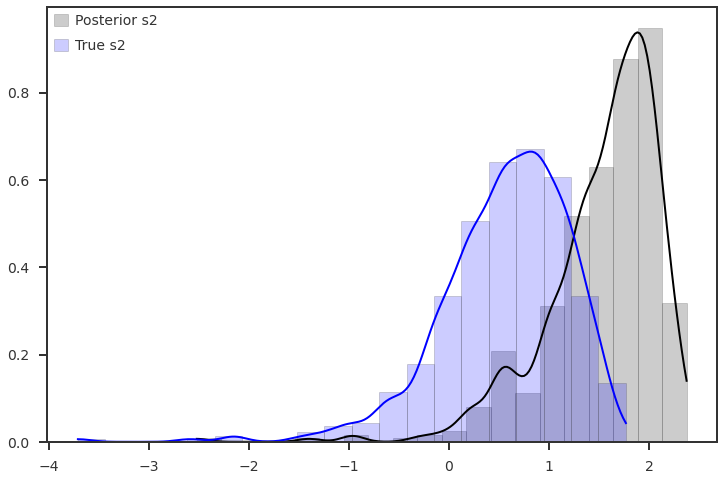

In [15]:
from scipy.stats import gaussian_kde as sp_gaussian_kde

def remove_outliers(data):
    quant3, quant1 = np.percentile(data, [75 ,25])
    iqr = quant3 - quant1
    xmin = quant1 - 1.5 * iqr
    xmax = quant3 + 1.5 * iqr
    Xkeep = np.array([x for x in data if (x >= xmin and x <= xmax)])
    return Xkeep

def density_plot(ax, data, label = '', color = 'k'):
    x = data.copy()
    #x = remove_outliers(data)
    xmin = np.min(x)
    xmax = np.max(x)
    kernel = sp_gaussian_kde(x)
    # smoothing
    kernel.covariance_factor = lambda : .2
    kernel._compute_covariance()
    
    xvals  = np.linspace(xmin, xmax, 200)
    density = kernel(xvals)
    ax.hist(x, density = True, label = label, color = color, alpha = 0.2)
    ax.plot(xvals, density, lw = 2, color = color)
    return

fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(111)

bzero = b.copy()

h, dhdb, _, dhds2 = nm_penalty(bzero, postprior, s2, dj)
xvals = np.log10(np.abs(dhdb))
print (h, dhds2)
density_plot(ax1, xvals, label = 'Posterior s2')

h, dhdb, _, dhds2 = nm_penalty(bzero, postprior, s2true, dj)
xvals = np.log10(np.abs(dhdb))
print (h, dhds2)
density_plot(ax1, xvals, label = 'True s2', color = 'blue')

# h, dhdb, _, _ = nm_penalty(b, prior, s2, dj)
# xvals = np.log10(np.abs(dhdb))
# print(h)
# density_plot(ax1, xvals, label = 'True Prior', color = 'blue')

# h, dhdb, _, _ = nm_penalty(b, initprior, s2, dj)
# xvals = np.log10(np.abs(dhdb))
# print(h)
# density_plot(ax1, xvals, label = 'Initial Prior', color = 'red')

ax1.legend()
plt.show()